In [1]:
%matplotlib inline
# load the autoreload extension
%load_ext autoreload
# autoreload mode 2, which loads imported modules again 
# everytime they are changed before code execution.
# So we don't need to restart the kernel upon changes to modules
%autoreload 2

In [2]:
!pip install --upgrade typing
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn #CUDA Deep Neural Network Library
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import time
import os
from tempfile import TemporaryDirectory

from PIL import Image
cudnn.benchmark = True
plt.ion()
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
DATA_DIR='./data'
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]
transform_train = transforms.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomCrop(32, padding=4),
    v2.RandomHorizontalFlip(p=0.5), #flip given a probability
    v2.ToImage(), # only needed if you don't have an PIL image
    v2.ToDtype(torch.float32, scale=True), #Normalize expects float input. scale the value?
    v2.Normalize(mean, std), #normalize with CIFAR mean and std
])
transform_test = transforms.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    # v2.RandomHorizontalFlip(p=0.5), #flip given a probability
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True), #Normalize expects float input. scale the value?
    v2.Normalize(mean, std), #normalize with CIFAR mean and std
])
train_data = torchvision.datasets.CIFAR10(root=DATA_DIR, train = True, transform = transform_train, download = True)
test_data = torchvision.datasets.CIFAR10(root=DATA_DIR, train = False, transform = transform_test, download = True)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, num_workers=1, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False, num_workers=1, pin_memory=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device)

Files already downloaded and verified
Files already downloaded and verified
device:  cpu


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.05098036339282991..1.0000000339984894].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9659271205684234e-08..0.9686275426864625].


[[[0.61960787 0.43921572 0.19215686]
  [0.62352943 0.43529415 0.18431369]
  [0.64705885 0.454902   0.20000001]
  ...
  [0.53725493 0.37254903 0.14117645]
  [0.49411767 0.35686276 0.14117645]
  [0.45490199 0.33333334 0.12941173]]

 [[0.59607846 0.43921572 0.20000001]
  [0.59215689 0.43137258 0.15686271]
  [0.62352943 0.44705886 0.17647056]
  ...
  [0.53333336 0.37254903 0.1215686 ]
  [0.49019611 0.35686276 0.12549017]
  [0.46666669 0.34509804 0.1333333 ]]

 [[0.59215689 0.43137258 0.18431369]
  [0.59215689 0.42745102 0.12941173]
  [0.61960787 0.43529415 0.14117645]
  ...
  [0.54509806 0.38431377 0.1333333 ]
  [0.50980395 0.37254903 0.1333333 ]
  [0.47058826 0.34901962 0.12941173]]

 ...

 [[0.26666667 0.48627454 0.69411767]
  [0.16470587 0.3921569  0.58039218]
  [0.1215686  0.34509804 0.53725493]
  ...
  [0.14901959 0.38039219 0.57254905]
  [0.05098036 0.2509804  0.42352944]
  [0.15686272 0.33333334 0.49803925]]

 [[0.2392157  0.454902   0.65882355]
  [0.19215687 0.40000004 0.58039218]


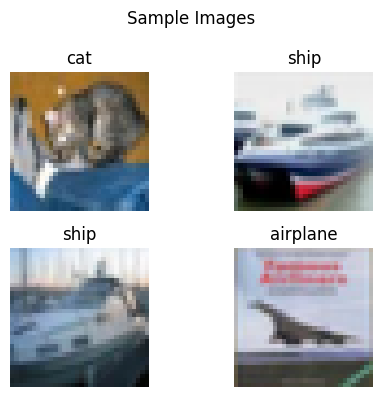

In [43]:
class_names = train_data.classes
def denorm(img):
    m = np.array(mean)
    s = np.array(std)
    img = img.numpy() * s + m
    return img

ROWS, CLM=2, 2
fig, axes = plt.subplots(nrows=ROWS, ncols=CLM)
fig.suptitle('Sample Images')
features, labels=next(iter(test_dataloader))
for i, ax in enumerate(axes.flat):
    img = denorm(features[i].permute(1,2,0).squeeze())
    # img = features[i].permute(1,2,0).squeeze().numpy()
    print(img)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(class_names[labels[i].item()])
plt.tight_layout()
plt.imshow(img)

In [6]:
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

- `loss.item()` gives the average loss across the current batch
- `model.eval()` and `model.train()`?

In [7]:
# model = models.resnet50(weights='IMAGENET1K_V1') # This is close to the training result in paper. V2 is better
# num_features = model.fc.in_features
# model.fc = nn.Linear(num_features, 10)
# model = model.to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# # Decay learning rate by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [8]:
def conv_3x3(in_channels, out_channels, stride, padding):
    return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            stride=stride,
            padding=padding,
            bias=False,
        )
    
def conv_1x1(in_channels, out_channels, stride):
    return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=1,
            stride=stride,
            padding=0,
            bias=False,
        )
     
class BasicIdentityBlock(nn.Module):
    """This is not the bottleneck block, it's the basic identity block
    Basic means there are 2 convolutions (3x3) back to back
    Identity means the skip connection does not require 1x1 convolution for reshaping 
    """
    def __init__(self, in_channels, out_channels, stride) -> None:
        # first conv layer is in charge of the actual stride
        super().__init__()
        self.conv1 = conv_3x3(in_channels=in_channels, 
                              out_channels=out_channels, stride=stride, padding=1,)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        # second conv does same convolution
        self.conv2 = conv_3x3(in_channels=out_channels, 
                              out_channels=out_channels, stride=1, padding=1,)
        
        self.bn2 = nn.BatchNorm2d(out_channels)
        # since this is identity, we can add outputs with inputs together, if stride is 1
        # In case in_channels!=out_channels
        if stride != 1 or in_channels!=out_channels:
            # this is downsampling. Downsampling in ResNet is done thru conv layer 
            self.short_cut = nn.Sequential(
                conv_1x1(in_channels=in_channels, out_channels=out_channels, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.short_cut = nn.Identity()

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        short_cut = self.short_cut(x)
        out += short_cut
        out = self.relu(out)
        return out
        

class ResNetCIFAR(nn.Module):
    def __init__(self, block, num_blocks, num_classes) -> None:
        # input_shape = (64, 64, 3)
        super().__init__()
        # same padding, output 32x32x16
        output_channels = [16, 16, 32, 64]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=output_channels[0], kernel_size=(3, 3), stride=1,
                               padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_features=output_channels[0])
        # 32x32x16
        self.layer0 = self._make_layer(block, num_blocks[0], in_channels = output_channels[0], out_channels=output_channels[1], stride=1)  
        # 16x16x32
        self.layer1 = self._make_layer(block, num_blocks[1], in_channels = output_channels[1], out_channels=output_channels[2], stride=2)  # 16x16
        # 8x8x64
        self.layer2 = self._make_layer(block, num_blocks[2], in_channels = output_channels[2], out_channels=output_channels[3], stride=2)  # 8x8
        self.relu=nn.ReLU(inplace=True)
        # output 1x1x64
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(in_features=output_channels[3], out_features=num_classes)   #10

        self._initialize_weights()
        
    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

    def _make_layer(self, block, num_block, in_channels, out_channels, stride):
        # first block may downsample
        layers = [
            block(in_channels, out_channels=out_channels, stride=stride)
        ]
        for _ in range(num_block-1):
            layers.append(block(in_channels=out_channels, out_channels=out_channels, stride=1))
        return nn.Sequential(*layers)
            
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

# resnet-20
model = ResNetCIFAR(block=BasicIdentityBlock, num_blocks=[3,3,3], num_classes=len(train_data.classes))
input_tensor_test = torch.randn(1,3,32,32)
output = model(input_tensor_test)
print(output.shape)

torch.Size([1, 10])


In [9]:
import time
# Define the training function
MODEL_PATH = 'resnet_cifar10.pth'
ACCUMULATION_STEPS = 8
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=25, device='cpu'):
    model.to(device)

    for epoch in range(num_epochs):
        # Training phase
        start = time.time()
        print(f'Epoch [{epoch + 1}/{num_epochs}] ')
        
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            # This is because torch.nn.CrossEntropyLoss(reduction='mean') is true, so to simulate a larger batch, we need to further divide
            loss = criterion(outputs, labels)/ACCUMULATION_STEPS
            # Backward pass and optimization
            loss.backward()
        
            if (i+1)%ACCUMULATION_STEPS == 0:
                optimizer.step()
                # Zero the parameter gradients
                optimizer.zero_grad()
                # break #TODO

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total_train += labels.size(0)
            correct_train += predicted.eq(labels).sum().item()

        # adjust after every epoch
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current learning rate: {current_lr}")

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100. * correct_train / total_train
        print("correct train: ", correct_train, " total train: ", total_train)

        torch.save(model.state_dict(), MODEL_PATH)
        print(f"epoch: {epoch}, saved the model. "
              f'Train Loss: {epoch_loss:.4f} '
              f'Train Acc: {epoch_acc:.2f}% ')
        
    # Evaluation phase
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        # for inputs_test, labels_test in train_loader:
        
        # TODO I AM ITERATING OVER TRAIN_LOADER, SO I'M MORE SURE
        for inputs_test, labels_test in test_loader:
            inputs_test = inputs_test.to(device)
            labels_test = labels_test.to(device)
            outputs_test = model(inputs_test)
            _, predicted_test = outputs_test.max(1)
            total_test += labels_test.size(0)
            correct_test += predicted_test.eq(labels_test).sum().item()

    test_acc = 100. * correct_test / total_test

    # Adjust learning rate
    end = time.time()
    print("elapsed: ", end-start)
    print(f'Test Acc: {test_acc:.2f}%')

    print('Training complete')
    return model

In [10]:
import os

# Train the model
if os.path.exists(MODEL_PATH):
    model.load_state_dict(torch.load(MODEL_PATH, weights_only=False, map_location=device))
    print("loaded model")
model.to(device)

criterion = nn.CrossEntropyLoss()
weight_decay = 0.0001
momentum=0.9
learning_rate=0.1
num_epochs=50
batch_size=16
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # 0.001 as learning rate is common
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

# Learning rate scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)

# # On a single Nvidia A10G GPU, an epoch takes ~170s
# model = train_model(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler,
#                     num_epochs=num_epochs, device=device)

loaded model


## Data Validation Processing

In [35]:
# Define the root directory where the dataset will be stored
voc_root = './data'

# Year of the dataset (2007 or 2012)
year = '2007'

# Create the dataset
transform_voc = transforms.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.Resize((32,32)),
    v2.ToTensor(),
    v2.Normalize(mean, std), #normalize with CIFAR mean and std
])

# These are handpicked VOC->CIFAR-10 mapping. If VOC's label doesn't fall into this dictionary, we shouldn't feed it to the model.
class_additional_mapping = {'aeroplane': 'airplane', 'car': 'automobile', 'bird':'bird', 'cat':'cat', 'dog':'dog', 'frog':'frog'}

mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]

import torch
from torch.utils.data import Dataset
from PIL import Image

class FilteredVOCtoCIFARDataset(Dataset):
    def __init__(self, root, year, image_set, transform=None, class_mapping=None):
        self.voc_dataset = torchvision.datasets.VOCDetection(
            root=root,
            year=year,
            image_set=image_set,
            download=True,
            transform=None  # Transform applied manually later
        )
        self.transform = transform
        self.class_mapping = class_mapping
        self.filtered_indices = self._filter_indices()

    def _filter_indices(self):
        indices = []
        for idx in range(len(self.voc_dataset)):
            target = self.voc_dataset[idx][1]  # Get the annotation
            objects = target['annotation'].get('object', [])
            if not isinstance(objects, list):
                objects = [objects]  # Ensure it's a list of objects
            if len(objects) > 1:
                continue
            obj = objects[0]
            label = obj['name']
            if label in self.class_mapping:  # Check if class is in our mapping
                indices.append(idx)
        return indices

    def __len__(self):
        return len(self.filtered_indices)

    def __getitem__(self, idx):
        actual_idx = self.filtered_indices[idx]
        image, target = self.voc_dataset[actual_idx]
        
        # Apply transformations to the image
        if self.transform:
            image = self.transform(image)

        # Map VOC labels to CIFAR-10 labels
        objects = target['annotation'].get('object', [])
        if not isinstance(objects, list):
            objects = [objects]  # Ensure it's a list of objects

        # Create a list of labels for the image
        labels = []
        for obj in objects:
            label = obj['name']
            if label in self.class_mapping:
                labels.append(self.class_mapping[label])

        # Return the image and the first label (as a classification task)
        return image, labels[0]  # In classification, return a single label per image

dataset = FilteredVOCtoCIFARDataset(
    root=voc_root,
    year='2007',
    image_set='val',
    transform=transform_voc,
    class_mapping=class_additional_mapping
)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=16,          # Adjust based on your memory constraints
    shuffle=True,
    num_workers=2,         # Adjust based on your system
    pin_memory=True
)


def display(imgs, labels, class_names):
    ROWS, CLM = 30, 2
    fig, axes = plt.subplots(nrows=ROWS, ncols=CLM, figsize=(8, 60))
    fig.suptitle('Sample Images')

    # Iterate through each subplot and image
    for i, ax in enumerate(axes.flat):
        if i >= len(imgs):
            break  # If fewer images than subplots, exit the loop

        img = imgs[i].permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
        img = img * torch.tensor(std).view(1, 1, 3) + torch.tensor(mean).view(1, 1, 3)  # De-normalize
        img = img.clamp(0, 1)  # Clamp values to the range [0, 1]

        ax.imshow(img)
        ax.axis("off")
        print(type(labels))
        ax.set_title(class_names[labels[i]])

    plt.tight_layout()
    plt.show()


/home/rico/.local/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


Using downloaded and verified file: ./data/VOCtrainval_06-Nov-2007.tar
Extracting ./data/VOCtrainval_06-Nov-2007.tar to ./data


In [38]:
# Should be brought to the front
def evaluate_model(model, dataloader):
    start = time.time()
    model.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        # for inputs_test, labels_test in train_loader:
        
        # TODO I AM ITERATING OVER TRAIN_LOADER, SO I'M MORE SURE
        predicted_labels = []
        all_images = []
        for images, labels in dataloader:
            images = images.to(device)
            labels = torch.tensor([
                class_names.index(label) for label in labels 
            ]).to(device)

            # torch.Size([16, 3, 32, 32])
            outputs_test = model(images)
            _, predicted_test = outputs_test.max(1)
            total_test += labels.size(0)
            correct_test += predicted_test.eq(labels).sum().item()
            predicted_labels+=list(predicted_test)
            all_images += images

    test_acc = 100. * correct_test / total_test

    # Adjust learning rate
    end = time.time()
    print("elapsed: ", end-start)
    print(f'Test Acc: {test_acc:.2f}%')

    print('Validation complete')
    return all_images, predicted_labels

all_images, predicted_labels = evaluate_model(model, dataloader)

elapsed:  1.1680748462677002
Test Acc: 61.00%
Validation complete


<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


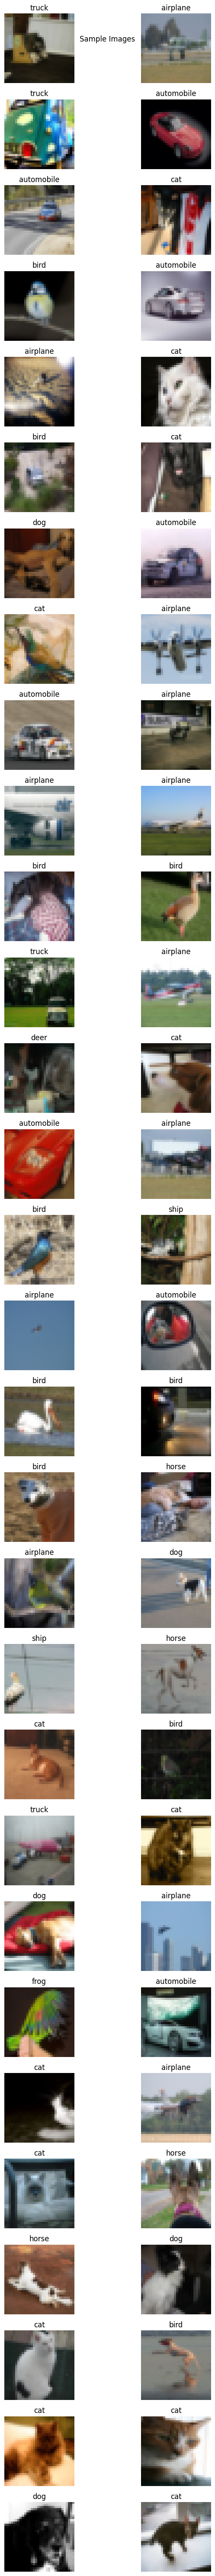

In [ ]:
display(all_images, predicted_labels, class_names)